## Load documents with IDs

In [2]:
import requests 

base_url = 'https://github.com/DataTalksClub/llm-zoomcamp/blob/main'
relative_url = '03-vector-search/eval/documents-with-ids.json'
docs_url = f'{base_url}/{relative_url}?raw=1'
docs_response = requests.get(docs_url)
documents = docs_response.json()

In [3]:
documents[10]

{'text': 'It depends on your background and previous experience with modules. It is expected to require about 5 - 15 hours per week. [source1] [source2]\nYou can also calculate it yourself using this data and then update this answer.',
 'section': 'General course-related questions',
 'question': 'Course - \u200b\u200bHow many hours per week am I expected to spend on this  course?',
 'course': 'data-engineering-zoomcamp',
 'id': 'ea739c65'}

## Load ground truth

In [4]:
import pandas as pd

base_url = 'https://github.com/DataTalksClub/llm-zoomcamp/blob/main'
relative_url = '03-vector-search/eval/ground-truth-data.csv'
ground_truth_url = f'{base_url}/{relative_url}?raw=1'

df_ground_truth = pd.read_csv(ground_truth_url)
df_ground_truth = df_ground_truth[df_ground_truth.course == 'machine-learning-zoomcamp']
ground_truth = df_ground_truth.to_dict(orient='records')

In [5]:
ground_truth[10]

{'question': 'Are sessions recorded if I miss one?',
 'course': 'machine-learning-zoomcamp',
 'document': '5170565b'}

In [6]:
doc_idx = {d['id']: d for d in documents}
doc_idx['5170565b']['text']

'Everything is recorded, so you won’t miss anything. You will be able to ask your questions for office hours in advance and we will cover them during the live stream. Also, you can always ask questions in Slack.'

In [7]:
doc_idx['5170565b']['id']

'5170565b'

## Index data

```
    docker run -it \
    --rm \
    --name elasticsearch \
    -m 4GB \
    -p 9200:9200 \
    -p 9300:9300 \
    -e "discovery.type=single-node" \
    -e "xpack.security.enabled=false" \
    docker.elastic.co/elasticsearch/elasticsearch:8.4.3
```

In [8]:
from sentence_transformers import SentenceTransformer

model_name = 'multi-qa-MiniLM-L6-cos-v1'
model = SentenceTransformer(model_name)

/usr/local/python/3.10.13/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
from elasticsearch import Elasticsearch

es_client = Elasticsearch('http://localhost:9200') 

index_settings = {
    "settings": {
        "number_of_shards": 1,
        "number_of_replicas": 0
    },
    "mappings": {
        "properties": {
            "text": {"type": "text"},
            "section": {"type": "text"},
            "question": {"type": "text"},
            "course": {"type": "keyword"},
            "id": {"type": "keyword"},
            "question_text_vector": {
                "type": "dense_vector",
                "dims": 384,
                "index": True,
                "similarity": "cosine"
            },
        }
    }
}

index_name = "course-questions"

es_client.indices.delete(index=index_name, ignore_unavailable=True)
es_client.indices.create(index=index_name, body=index_settings)

ObjectApiResponse({'acknowledged': True, 'shards_acknowledged': True, 'index': 'course-questions'})

In [10]:
from tqdm.auto import tqdm

for doc in tqdm(documents):
    question = doc['question']
    text = doc['text']
    doc['question_text_vector'] = model.encode(question + ' ' + text)

    es_client.index(index=index_name, document=doc)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 948/948 [01:20<00:00, 11.80it/s]


## Retrieval

In [11]:
def elastic_search_knn(field, vector, course):
    knn = {
        "field": field,
        "query_vector": vector,
        "k": 5,
        "num_candidates": 1000,
        "filter": {
            "term": {
                "course": course
            }
        }
    }

    search_query = {
        "knn": knn,
        "_source": ["text", "section", "question", "course", "id"]
    }

    es_results = es_client.search(
        index=index_name,
        body=search_query
    )
    
    result_docs = []
    
    for hit in es_results['hits']['hits']:
        result_docs.append(hit['_source'])

    return result_docs

def question_text_vector_knn(q):
    question = q['question']
    course = q['course']

    v_q = model.encode(question)

    return elastic_search_knn('question_text_vector', v_q, course)

In [12]:
question_text_vector_knn(dict(
    question='Are sessions recorded if I miss one?',
    course='machine-learning-zoomcamp'
))

[{'question': 'What if I miss a session?',
  'course': 'machine-learning-zoomcamp',
  'section': 'General course-related questions',
  'text': 'Everything is recorded, so you won’t miss anything. You will be able to ask your questions for office hours in advance and we will cover them during the live stream. Also, you can always ask questions in Slack.',
  'id': '5170565b'},
 {'question': 'Is it going to be live? When?',
  'course': 'machine-learning-zoomcamp',
  'section': 'General course-related questions',
  'text': 'The course videos are pre-recorded, you can start watching the course right now.\nWe will also occasionally have office hours - live sessions where we will answer your questions. The office hours sessions are recorded too.\nYou can see the office hours as well as the pre-recorded course videos in the course playlist on YouTube.',
  'id': '39fda9f0'},
 {'question': 'The same accuracy on epochs',
  'course': 'machine-learning-zoomcamp',
  'section': '8. Neural Networks an

## The RAG flow

### mixtral-8x7b-32768 model

In [13]:

def build_prompt(query, search_results):
    prompt_template = """
You're a course teaching assistant. Answer the QUESTION based on the CONTEXT from the FAQ database.
Use only the facts from the CONTEXT when answering the QUESTION.

QUESTION: {question}

CONTEXT: 
{context}
""".strip()

    context = ""
    
    for doc in search_results:
        context = context + f"section: {doc['section']}\nquestion: {doc['question']}\nanswer: {doc['text']}\n\n"
    
    prompt = prompt_template.format(question=query, context=context).strip()
    return prompt

In [1]:
import os
from groq import Groq

# Instantiation of Groq Client
client = Groq(
    api_key=os.environ.get("GROQ_API_KEY")
)

In [51]:
def llm(prompt, model_name="mixtral-8x7b-32768"):
    response = client.chat.completions.create(
    messages=[
        {
           "role": "user", "content": prompt
        }
    ],
    model=model_name,
    )
    return response.choices[0].message.content
        

In [50]:
def rag(query: dict, model_name="mixtral-8x7b-32768") -> str:
    search_results = question_text_vector_knn(query)
    prompt = build_prompt(query, search_results)
    answer = llm(prompt, model_name = model_name)
    return answer


In [16]:
ground_truth[10]

{'question': 'Are sessions recorded if I miss one?',
 'course': 'machine-learning-zoomcamp',
 'document': '5170565b'}

In [52]:
rag(ground_truth[10])

"Yes, sessions are recorded and you will be able to watch any session that you miss. This includes office hours as well as the pre-recorded course videos. If you miss a live session, you can still watch the recording and ask any questions you have in Slack. The specific issue of accuracy and loss being the same during training in the Neural Networks and Deep Learning section of the course is addressed by setting class\\_mode='binary' while reading the data and choosing the appropriate optimizer, batch size, or learning rate. A useful resource for missing data treatment can be found at <https://www.kaggle.com/code/parulpandey/a-guide-to-handling-missing-values-in-python/notebook>. Additionally, it is possible to still receive a certificate even if you miss the midterm project."

In [18]:
doc_idx['5170565b']['text']

'Everything is recorded, so you won’t miss anything. You will be able to ask your questions for office hours in advance and we will cover them during the live stream. Also, you can always ask questions in Slack.'

## Cosine similarity metric

In [19]:
answer_llm = 'If you miss one session and are unable to attend or fully participate in that particular live streamed office hour (since these sessions can occasionally occur), rest assured that everything will be recorded anyway so no content is missed out on. You have been advised by this course teaching assistant not only to ask your questions beforehand for the upcoming office hours but also to feel free to pose them ahead of time in Slack or during designated session times as it suits you best, thus ensuring full participation and engagement with the course material regardless of attendance at any individual live-streamed event.'
answer_orig = 'Everything is recorded, so you won’t miss anything. You will be able to ask your questions for office hours in advance and we will cover them during the live stream. Also, you can always ask questions in Slack.'

v_llm = model.encode(answer_llm)
v_orig = model.encode(answer_orig)

v_llm.dot(v_orig)

0.69527495

In [20]:
ground_truth[0]

{'question': 'Where can I sign up for the course?',
 'course': 'machine-learning-zoomcamp',
 'document': '0227b872'}

In [21]:
len(ground_truth)

1830

### Sampling

I sampled 50 instances from ground_truth dataset because of slow computation.

In [28]:
df_ground_truth = pd.DataFrame(ground_truth)

df_ground_truth_sampled = df_ground_truth.sample(n=50, random_state=1)
ground_truth_sampled = df_ground_truth_sampled.to_dict(orient='records')


In [29]:
answers = {}

In [30]:
for i, rec in enumerate(tqdm(ground_truth_sampled)):
    if i in answers:
        continue

    answer_llm = rag(rec)
    doc_id = rec['document']
    original_doc = doc_idx[doc_id]
    answer_orig = original_doc['text']

    answers[i] = {
        'answer_llm': answer_llm,
        'answer_orig': answer_orig,
        'document': doc_id,
        'question': rec['question'],
        'course': rec['course'],
    }

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [10:28<00:00, 12.58s/it]


In [31]:
results_mixtral = [None] * len(ground_truth_sampled)

for i, val in answers.items():
    results_mixtral[i] = val.copy()
    results_mixtral[i].update(ground_truth_sampled[i])

In [32]:
import pandas as pd


In [33]:
df_mixtral = pd.DataFrame(results_mixtral)
df_mixtral.to_csv('data/results-mixtral.csv', index=False)


## Evaluating in parallel

### llama3-8b-8192 model

In [61]:
from tqdm.auto import tqdm
from concurrent.futures import ThreadPoolExecutor

# Increase max_workers. I had to set it to 1 because of the rate limit
pool = ThreadPoolExecutor(max_workers=1)

def map_progress(pool, seq, f):
    results = []

    with tqdm(total=len(seq)) as progress:
        futures = []

        for el in seq:
            future = pool.submit(f, el)
            future.add_done_callback(lambda p: progress.update())
            futures.append(future)

        for future in futures:
            result = future.result()
            results.append(result)

    return results

In [58]:
def process_record(rec):
    answer_llm = rag(rec, model_name="llama3-8b-8192")
    
    doc_id = rec['document']
    original_doc = doc_idx[doc_id]
    answer_orig = original_doc['text']

    return {
        'answer_llm': answer_llm,
        'answer_orig': answer_orig,
        'document': doc_id,
        'question': rec['question'],
        'course': rec['course'],
    }

In [59]:
process_record(ground_truth_sampled[10])

{'answer_llm': 'Based on the provided context, for the question "What is the solution for the TensorFlow Serving error on Apple M1 Mac?" the solution is:\n\nUse the emacski/tensorflow-serving:latest image with the flag -linux_arm64. For example:\n\n```\ndocker run -it --rm \\\n-p 8500:8500 \\\n-v $(pwd)/clothing-model:/models/clothing-model/1 \\\n-e MODEL_NAME="clothing-model" \\\nemacski/tensorflow-serving:latest-linux_arm64\n```\n\nThe context also mentions a similar error on Mac M2 Apple Silicon, where the solution is to use the bitnami/tensorflow-serving:2 base image.\n\nNote: Please refer to the original document for more details and clarification.',
 'answer_orig': 'While trying to run the docker code on M1:\ndocker run --platform linux/amd64 -it --rm \\\n-p 8500:8500 \\\n-v $(pwd)/clothing-model:/models/clothing-model/1 \\\n-e MODEL_NAME="clothing-model" \\\ntensorflow/serving:2.7.0\nIt outputs the error:\nError:\nStatus: Downloaded newer image for tensorflow/serving:2.7.0\n[lib

In [60]:
results_llama = map_progress(pool, ground_truth_sampled, process_record)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [01:23<00:00,  1.68s/it]


In [68]:
df_llama= pd.DataFrame(results_llama)
df_llama.to_csv('data/results_llama.csv', index=False)

## Cosine similarity

### mixtral

In [38]:
results_mixtral = df_mixtral.to_dict(orient='records')
record = results_mixtral[0]


In [39]:
def compute_similarity(record):
    answer_orig = record['answer_orig']
    answer_llm = record['answer_llm']
    
    v_llm = model.encode(answer_llm)
    v_orig = model.encode(answer_orig)
    
    return v_llm.dot(v_orig)

In [40]:
similarity = []

for record in tqdm(results_mixtral):
    sim = compute_similarity(record)
    similarity.append(sim)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:05<00:00,  8.84it/s]


In [41]:
df_mixtral['cosine'] = similarity
df_mixtral['cosine'].describe()

count    50.000000
mean      0.645247
std       0.184242
min       0.105196
25%       0.545477
50%       0.695243
75%       0.768279
max       0.904874
Name: cosine, dtype: float64

### llama 

In [69]:
results_llama = df_llama.to_dict(orient='records')

similarity_llama = []

for record in tqdm(results_llama):
    sim = compute_similarity(record)
    similarity_llama.append(sim)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:04<00:00, 10.09it/s]


In [70]:
df_llama['cosine'] = similarity_llama
df_llama['cosine'].describe()

count    50.000000
mean      0.642625
std       0.205470
min       0.062774
25%       0.497982
50%       0.686011
75%       0.790700
max       0.943315
Name: cosine, dtype: float64

### Model performance comparison

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt


/tmp/ipykernel_23804/4000465224.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_mixtral['cosine'], label='mixtral')
/tmp/ipykernel_23804/4000465224.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_llama['cosine'], label='llama')


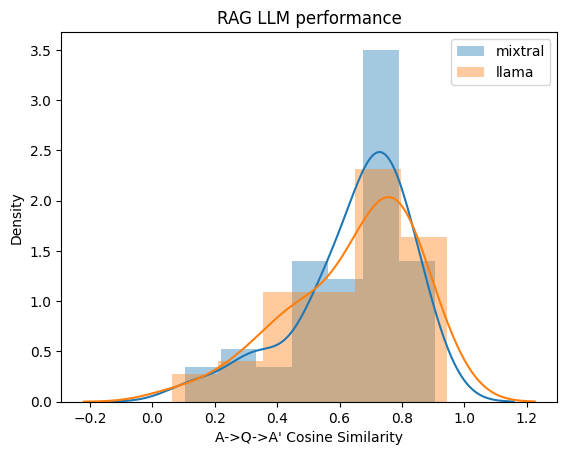

In [71]:
sns.distplot(df_mixtral['cosine'], label='mixtral')
sns.distplot(df_llama['cosine'], label='llama')

plt.title("RAG LLM performance")
plt.xlabel("A->Q->A' Cosine Similarity")
plt.legend()

## LLM as a judge

In [73]:
prompt1_template = """
You are an expert evaluator for a Retrieval-Augmented Generation (RAG) system.
Your task is to analyze the relevance of the generated answer compared to the original answer provided.
Based on the relevance and similarity of the generated answer to the original answer, you will classify
it as "NON_RELEVANT", "PARTLY_RELEVANT", or "RELEVANT".

Here is the data for evaluation:

Original Answer: {answer_orig}
Generated Question: {question}
Generated Answer: {answer_llm}

Please analyze the content and context of the generated answer in relation to the original
answer and provide your evaluation in parsable JSON without using code blocks:

{{
  "Relevance": "NON_RELEVANT" | "PARTLY_RELEVANT" | "RELEVANT",
  "Explanation": "[Provide a brief explanation for your evaluation]"
}}
""".strip()

prompt2_template = """
You are an expert evaluator for a Retrieval-Augmented Generation (RAG) system.
Your task is to analyze the relevance of the generated answer to the given question.
Based on the relevance of the generated answer, you will classify it
as "NON_RELEVANT", "PARTLY_RELEVANT", or "RELEVANT".

Here is the data for evaluation:

Question: {question}
Generated Answer: {answer_llm}

Please analyze the content and context of the generated answer in relation to the question
and provide your evaluation in parsable JSON without using code blocks:

{{
  "Relevance": "NON_RELEVANT" | "PARTLY_RELEVANT" | "RELEVANT",
  "Explanation": "[Provide a brief explanation for your evaluation]"
}}
""".strip()

In [77]:
record = results_mixtral[7]
record

{'answer_llm': "The main reason for different accuracy values in the context of the provided document is the way of splitting data into train, validation, and test sets. Specifically, the order and method of splitting the data can result in slightly different subsets of data, leading to differences in accuracy values. When evaluating feature elimination, it is recommended to calculate the smallest difference in accuracy in absolute values, not in real values. Additionally, when comparing accuracy scores, it is recommended to take the smallest absolute difference, since the order of subtraction can result in a negative number. The actual values predicted by a neural network should be treated as a likelihood of falling into a class, with some small changes expected. The choice between using ROC curves or Precision-Recall curves depends on the balance of observations between each class. ROC curves are appropriate for balanced datasets, while Precision-Recall curves are better suited for i

In [78]:
prompt = prompt1_template.format(**record)
print(prompt)

You are an expert evaluator for a Retrieval-Augmented Generation (RAG) system.
Your task is to analyze the relevance of the generated answer compared to the original answer provided.
Based on the relevance and similarity of the generated answer to the original answer, you will classify
it as "NON_RELEVANT", "PARTLY_RELEVANT", or "RELEVANT".

Here is the data for evaluation:

Original Answer: One main reason behind that, is the way of splitting data. For example, we want to split data into train/validation/test with the ratios 60%/20%/20% respectively.
Although the following two options end up with the same ratio, the data itself is a bit different and not 100% matching in each case.
1)
df_train, df_temp = train_test_split(df, test_size=0.4, random_state=42)
df_val, df_test = train_test_split(df_temp, test_size=0.5, random_state=42)
2)
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_s

In [79]:
answer = llm(prompt)

In [84]:
answer

'{\n  "Relevance": "PARTLY_RELEVANT",\n  "Explanation": "The generated answer discusses the impact of data splitting on accuracy values, which is related to the original answer. However, it elaborates on additional aspects not mentioned in the original answer, such as the order of splitting, the recommendation to calculate the smallest difference in absolute values, and the choice between ROC and Precision-Recall curves. While these topics are related to machine learning, they deviate from the specific issue in the original answer regarding the consistency of different splitting methods."\n}'

In [85]:
import json
json.loads(answer)

{'Relevance': 'PARTLY_RELEVANT',
 'Explanation': 'The generated answer discusses the impact of data splitting on accuracy values, which is related to the original answer. However, it elaborates on additional aspects not mentioned in the original answer, such as the order of splitting, the recommendation to calculate the smallest difference in absolute values, and the choice between ROC and Precision-Recall curves. While these topics are related to machine learning, they deviate from the specific issue in the original answer regarding the consistency of different splitting methods.'}

In [81]:
evaluations = []

for record in tqdm(results_mixtral):
    prompt = prompt1_template.format(**record)
    evaluation = llm(prompt)
    evaluations.append(evaluation)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [05:18<00:00,  6.37s/it]


In [90]:
evaluations[8]

'{\n  "Relevance": "RELEVANT",\n  "Explanation": "The generated answer addresses the user\'s concern about losing the REMOTE\\_URI variable after the session ends by providing steps to manually set the variable again in the terminal. These steps are consistent with the original answer, ensuring that the user can continue to use the URI address for logging in to the registry."\n}'

In [99]:
i

8

In [104]:
evaluations[8]= '{\n  "Relevance": "RELEVANT",\n  "Explanation": "The generated answer addresses the user s concern about losing the REMOTE URI variable after the session ends by providing steps to manually set the variable again in the terminal. These steps are consistent with the original answer, ensuring that the user can continue to use the URI address for logging in to the registry."\n}'

In [107]:
json_evaluations = []

for i, str_eval in enumerate(evaluations):
    json_eval = json.loads(str_eval)
    json_evaluations.append(json_eval)

In [108]:
df_evaluations = pd.DataFrame(json_evaluations)


In [109]:
df_evaluations.Relevance.value_counts()


Relevance
RELEVANT           30
PARTLY_RELEVANT    16
NON_RELEVANT        4
Name: count, dtype: int64

In [110]:
df_evaluations[df_evaluations.Relevance == 'NON_RELEVANT'] #.to_dict(orient='records')


,Relevance,Explanation
4,NON_RELEVANT,The generated answer discusses a version confl...
10,NON_RELEVANT,The generated answer suggests using the bitnam...
11,NON_RELEVANT,The generated answer does not address the issu...
27,NON_RELEVANT,The generated answer does not provide any info...


In [111]:
results_mixtral[4]

{'answer_llm': 'The cause of the pip version error in this week\'s serverless deep learning section is likely a version conflict in Scikit-Learn. When creating a virtual environment, it is important to use the same version of Scikit-Learn that was used for training the model. In this case, the error was encountered when the training was done using Scikit-Learn version 1.1.1, but the virtual environment had a different version. The solution is to ensure that the model and other files are created using the same version of Scikit-Learn that is being used for the project by running "pipenv install scikit-learn==1.1.1".',
 'answer_orig': 'When running docker build -t dino-dragon-model it returns the above error\nThe most common source of this error in this week is because Alex video shows a version of the wheel with python 8, we need to find a wheel with the version that we are working on. In this case python 9. Another common error is to copy the link, this will also produce the same error

In [112]:
prompt = prompt2_template.format(**record)
print(prompt)

You are an expert evaluator for a Retrieval-Augmented Generation (RAG) system.
Your task is to analyze the relevance of the generated answer to the given question.
Based on the relevance of the generated answer, you will classify it
as "NON_RELEVANT", "PARTLY_RELEVANT", or "RELEVANT".

Here is the data for evaluation:

Question: Do you have a YouTube video covering Evaluation Metrics for Classification?
Generated Answer: Based on the provided context, there is no information about a YouTube video covering Evaluation Metrics for Classification in the 'machine-learning-zoomcamp' course. However, I can provide you with the ways to get classification metrics using scikit-learn, as well as a method to create a beautiful classification report using Yellowbrick.

To get classification metrics using scikit-learn, you can use the following off-the-shelf functions available in the scikit-learn library:

```python
from sklearn.metrics import (accuracy_score,
                               precisi

In [113]:
evaluation = llm(prompt)
print(evaluation)

{
  "Relevance": "PARTLY_RELEVANT",
  "Explanation": "The generated answer does not directly address the question about a YouTube video covering Evaluation Metrics for Classification in the 'machine-learning-zoomcamp' course. However, it does provide relevant information on how to get classification metrics using scikit-learn and create a classification report using Yellowbrick, which could be considered partly relevant to the topic of evaluation metrics."
}


In [114]:
evaluations_2 = []

for record in tqdm(results_mixtral):
    prompt = prompt2_template.format(**record)
    evaluation = llm(prompt)
    evaluations_2.append(evaluation)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [03:38<00:00,  4.37s/it]


In [115]:
json_evaluations_2 = []

for i, str_eval in enumerate(evaluations_2):
    json_eval = json.loads(str_eval)
    json_evaluations_2.append(json_eval)

In [116]:
df_evaluations_2 = pd.DataFrame(json_evaluations_2)
df_evaluations_2[df_evaluations_2.Relevance == 'NON_RELEVANT']


,Relevance,Explanation
11,NON_RELEVANT,The generated answer does not address the ques...
27,NON_RELEVANT,The generated answer does not provide any info...


In [117]:
df_evaluations_2.Relevance.value_counts()


Relevance
RELEVANT           41
PARTLY_RELEVANT     7
NON_RELEVANT        2
Name: count, dtype: int64

In [118]:
results_mixtral[11]

{'answer_llm': 'The question asks about resolving a `NotSupportedError` in section 5 of the machine learning course. However, the context provided does not contain any information related to this error in that section. Instead, there are answers related to other errors in different sections.\n\nOne of the answers relates to a `TypeError: Descriptors cannot not be created directly` error in section 10.3. The solution provided is to downgrade the protobuf package to version 3.20.1 using pipenv. You can try running the following command:\n\n```bash\npipenv install protobuf==3.20.1\n```\n\nIf you are not using pipenv, you can try downgrading the protobuf package using pip instead:\n\n```bash\npip install protobuf==3.20.1\n```\n\nIf you encounter a permission error when using pip, you can try using the `--user` option:\n\n```bash\npip --user install protobuf==3.20.1\n```\n\nNote that this solution is not specific to section 5 or the `NotSupportedError`, but it may still help resolve the iss

## Saving all data

In [72]:
df_mixtral.to_csv('data/results-mixtral-cosine.csv', index=False)
df_llama.to_csv('data/results-llama-cosine.csv', index=False)


In [119]:
df_evaluations.to_csv('data/evaluations-aqa.csv', index=False)
df_evaluations_2.to_csv('data/evaluations-qa.csv', index=False)